In [ ]:
#@title Mount Google Drive (optional) and create outputs folder
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    outputs_path = "/content/gdrive/MyDrive/AI/iadb-fun"
except:
    outputs_path = "./outputs"
import os
os.makedirs(outputs_path, exist_ok=True)
print(f"Outputs will be saved to {outputs_path}")

In [ ]:
#@title Installation
import os
import random
import sys
import torch
import torchvision

from IPython.display import clear_output
from torchvision.datasets.utils import download_url

if os.path.exists("../iadb.py"):
    sys.path.append("..") # use local src
else:
    !git clone https://github.com/pharmapsychotic/iadb-fun
    !pip install -r iadb-fun/requirements.txt
    sys.path.append("./iadb-fun") # use github src

from diffusers import AutoencoderKL
from tqdm import tqdm

import iadb

# Set of pre-trained models
PRETRAINED_REPO = "https://huggingface.co/pharma/iadb/resolve/main/"
MODELS = {
    "cats64": ("cats64.yaml", "cats64_2738.safetensors"),
    "cats512": ("cats512_vae.yaml", "cats512_vae_217.safetensors"),
    "celeba64": ("celeba64.yaml", "celeba64_131.safetensors"),
}

# Load a pre-trained model

In [ ]:
#@title Load a pre-trained model
model = "cats512" #@param ["cats64", "cats512", "celeba64"]

# Download config and weights
cache_path = os.path.join("cache", model)
os.makedirs(cache_path, exist_ok=True)
download_url(PRETRAINED_REPO + MODELS[model][0], cache_path)
download_url(PRETRAINED_REPO + MODELS[model][1], cache_path)
config_path = os.path.join(cache_path, MODELS[model][0])
model_path = os.path.join(cache_path, MODELS[model][1])

config = iadb.config_load(config_path)
model = iadb.model_from_config(config)
iadb.model_load_weights(model, model_path)
resolution = config.get('resolution', 64)
uses_vae = config.get('vae_latents', False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

if uses_vae:
    vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse")
    vae = vae.eval().to(device)
else:
    vae = None

def sample_model(model, seed, steps, batch_size=1, sampler="euler"):
    # create random starting gaussian noise
    if isinstance(seed, int):
        torch.manual_seed(seed)
        if vae:
            x0 = torch.randn(batch_size, 4, resolution//8, resolution//8, device=device)
        else:
            x0 = torch.randn(batch_size, 3, resolution, resolution, device=device)
    else:
        x0 = seed

    # use the model to map from distribution of gaussian noise to distribution of images
    if sampler == "euler":
        samples = iadb.sample_euler(model, x0, steps)
    else:
        samples = iadb.sample_runge_kutta(model, x0, steps)

    # decode VAE latents if needed
    if vae:
        with torch.no_grad():
            samples = vae.decode(1/0.18215 * samples).sample

    # remap from -1,1 to 0,1
    samples = samples.mul(0.5).add(0.5).clamp(0, 1).cpu()

    return [
        torchvision.transforms.functional.to_pil_image(samples[i])
        for i in range(batch_size)
    ]

# Render images

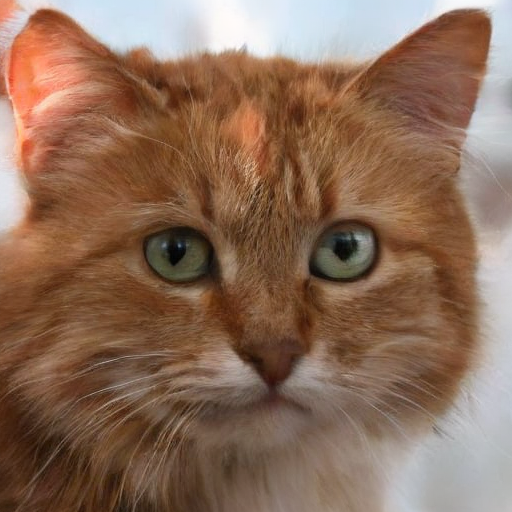

In [45]:
#@title Image creation

#@markdown Settings
batch_size = 1 #@param {type:"integer"}
num_batches = 1 #@param {type:"integer"}
sampler = "rk4" #@param ["euler", "rk4"]
seed = -1 #@param {type:"integer"}
steps = 8 #@param {type:"integer"}

# seed with given value or pick one at random if -1
seed = random.randint(0, 2**32-1) if seed == -1 else seed

for batch_idx in range(num_batches):
    images = sample_model(model, seed, steps, batch_size, sampler)
    clear_output(wait=True)
    for i, image in enumerate(images):
        if batch_size == 1:
            image.save(f"{outputs_path}/{seed}.png")
        else:
            image.save(f"{outputs_path}/{seed}_{i:02d}.png")
        display(image)
    seed += 1

# Animation

In [ ]:
#@title Interpolate between seeds
seeds = "25, 21, 20, 18, 6, 25" #@param {type:"string"}
frames_per_span = 12 #@param {type:"integer"}

sampler = "rk4" #@param ["euler", "rk4"]
steps = 16 #@param {type:"integer"}
ease_in_out = False #@param {type:"boolean"}

seeds = [int(n) for n in seeds.split(",")]

def slerp(a, b, t):
    angle = torch.acos((a / torch.norm(a)) * (b / torch.norm(b)))
    sa = torch.sin(angle)
    return (torch.sin((1.0 - t) * angle) / sa) * a + (torch.sin(t * angle) / sa) * b

frame_idx = 0
for span in range(len(seeds)-1):
    channels, factor = (4, 8) if vae else (3, 1)
    torch.manual_seed(seeds[span])
    a = torch.randn(1, channels, resolution//factor, resolution//factor, device=device)
    torch.manual_seed(seeds[span + 1])
    b = torch.randn(1, channels, resolution//factor, resolution//factor, device=device)

    for i in tqdm(range(frames_per_span)):
        t = float(i) / frames_per_span
        if ease_in_out:
            t = 3*t**2 - 2*t**3
        x0 = slerp(a, b, t)
        image = sample_model(model, x0, steps, batch_size, sampler)[0]
        image.save(f"{outputs_path}/frame_{frame_idx:04d}.png")
        frame_idx += 1
        clear_output(wait=True)
        display(image)

# compile frames into video
!ffmpeg -y -r 24 -i {outputs_path}/frame_%04d.png -vcodec libx264 -pix_fmt yuv420p {outputs_path}/out.mp4

# display video
clear_output(wait=True)
from IPython.display import HTML
from base64 import b64encode
mp4 = open(f"{outputs_path}/out.mp4",'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""
<video width=512 controls autoplay loop>
        <source src="{data_url}" type="video/mp4">
</video>""")
